# Lọc dữ liệu OCO trong khu vực trồng lúa

Lọc dữ liệu OCO trong khu vực trồng lúa
Sử dụng dữ liệu ALOS Landcover (CSV format) để lọc các điểm OCO
nằm trong vùng trồng lúa (buffer 500m)

Input:
- OCO CSV: longitude, latitude, ...
- Landcover CSV: longitude, latitude, landcover_value (0-12)


## 1. Import thư viện

In [1]:
import pandas as pd # xử lý dữ liệu dạng bảng
import numpy as np # xử lý dữ liệu số
import geopandas as gpd # xử lý dữ liệu không gian
import rasterio # đọc và ghi dữ liệu raster
from rasterio.mask import mask # Căt ảnh raster theo vùng
from shapely.geometry import Point, mapping # xử lý dữ liệu hình học
import matplotlib.pyplot as plt # vẽ biểu đồ
from scipy.spatial import cKDTree # cấu trúc dữ liệu KD-Tree để tìm kiếm nhanh


## 2. Hàm tạo buffer 500m quanh điểm OCO-2

In [2]:
def create_buffer_500m(lon, lat):
    """
    Tạo buffer 500m quanh điểm OCO-2
    """
    # Tạo 1 đối tượng điểm từ tọa longtitude và latitude của điểm đo CO2
    point = Point(lon, lat) 
    # Tạo GeoDataFrame với hệ tọa độ WGS84
    gdf = gpd.GeoDataFrame([1], geometry=[point], crs="EPSG:4326")
    # Vùng chiếu UTM phù hợp: UTM chia trái đất thành 60 múi chiếu(mỗi múi 6 độ) 
    utm_zone = int((lon + 180) / 6) + 1
    hemisphere = 'north' if lat >= 0 else 'south'
    epsg_code = 32600 + utm_zone if hemisphere == 'north' else 32700 + utm_zone
    # Chuyển từ WGS84 sang UTM để tạo buffer 500m
    gdf_utm = gdf.to_crs(f"EPSG:{epsg_code}")
    # tạo buffer bán kính 500m sinh vùng tròn 500m quanh điểm đo CO2
    buffer_utm = gdf_utm.buffer(500)
    # Chuyển ngược vùng buffer về WGS84
    buffer_wgs84 = buffer_utm.to_crs("EPSG:4326")
    # trả về hình học của vùng buffer
    return buffer_wgs84.geometry.iloc[0]
## Mục tiêu: mỗi điểm CO2 sẽ có vùng đệm (buffer) bán kính 500m để phân tích vùng xung quanh nó


## 3. Load dữ liệu Landcover

In [3]:
def load_landcover_data(landcover_csv_path, rice_value=3):
    """
    Đọc dữ liệu landcover(lớp phủ đất) từ CSV và chuẩn bị dữ liệu "ruộng lúa" để so sánh
    """
    print("\n[*] Đọc dữ liệu landcover...")
    
    # Đọc file CSV chứa các điểm có thông tin longitude, latitude và landcover_value
    landcover_df = pd.read_csv(landcover_csv_path)
    
    # In các thông tin cơ bản về dữ liệu landcover
    print(f"✓ Đã đọc {len(landcover_df):,} điểm landcover")
    print(f"✓ Các cột: {landcover_df.columns.tolist()}")
    
    # In các giá trị landcover_value duy nhất trong dữ liệu
    unique_values = sorted(landcover_df['landcover_value'].unique())
    print(f"✓ Các giá trị landcover: {unique_values}")
    
    # Lọc riêng các điểm có landcover_value tương ứng với "ruộng lúa" (= 3)
    rice_df = landcover_df[landcover_df['landcover_value'] == rice_value].copy()
    print(f"✓ Số điểm ruộng lúa (value={rice_value}): {len(rice_df):,}")
    
    # Kiểm tra nếu không có điểm ruộng lúa nào
    if len(rice_df) == 0:
        raise ValueError(f"Không tìm thấy điểm nào có landcover_value = {rice_value}")
    
    # Chuyển các tọa độ thành đối tượng hình học Point và tạo GeoDataFrame
    geometry = [Point(xy) for xy in zip(rice_df['longitude'], rice_df['latitude'])]
    rice_gdf = gpd.GeoDataFrame(rice_df, geometry=geometry, crs="EPSG:4326")
    
    # Xây dựng cấu trúc dữ liệu KD-Tree để tìm kiếm nhanh các điểm gần nhau
    coords = np.column_stack([rice_df['longitude'].values, rice_df['latitude'].values])
    tree = cKDTree(coords)
    
    # trả về dữ liệu ruộng lúa + chỉ mục tìm kiếm nhanh
    return rice_gdf, tree, coords


## 4. Kiểm tra vùng lúa chi tiết


In [4]:
# Yêu cầu: pip install scikit-learn
import numpy as np
from sklearn.neighbors import BallTree
import math
from shapely.geometry import Point

# chuẩn bị: tạo BallTree từ rice_coords (lon,lat) -> to radians (lat, lon) order cần lưu ý
# BallTree haversine expects points as [lat_rad, lon_rad] if you use haversine metric with radius in radians.

def build_balltree_from_gdf(rice_gdf):
    # rice_gdf.columns: longitude, latitude (assumed)
    coords_rad = np.deg2rad(np.vstack([rice_gdf['latitude'].values, rice_gdf['longitude'].values]).T)
    # BallTree expects shape (n_samples, 2) with order (lat, lon)
    tree = BallTree(coords_rad, metric='haversine')
    return tree, coords_rad

def check_rice_with_balltree(lon, lat, rice_gdf, tree, rice_coords_rad, threshold=0.5):
    """
    lon,lat in degrees
    tree built with BallTree on radians with order (lat, lon)
    """
    try:
        # 1) create buffer polygon in meters using your create_buffer_500m (which returns WGS84 polygon)
        buffer_geom = create_buffer_500m(lon, lat)
        
        # 2) query BallTree: convert center to radians (lat, lon order)
        center_rad = np.deg2rad([lat, lon])
        # haversine radius = distance_m / earth_radius_m
        earth_radius = 6371000.0
        radius_rad = 500.0 / earth_radius
        
        # indices of candidate points
        indices = tree.query_radius(center_rad.reshape(1, -1), r=radius_rad)[0]
        if indices.size == 0:
            return False
        
        candidate_points = rice_gdf.iloc[indices]
        points_in_buffer = candidate_points[candidate_points.within(buffer_geom)]
        
        rice_count = len(points_in_buffer)
        total_count = len(candidate_points)
        if total_count == 0:
            return False
        rice_ratio = rice_count / total_count
        return rice_count > 0 and rice_ratio >= threshold
    except Exception as e:
        print(f"Error at ({lon},{lat}): {e}")
        return False


In [6]:
def check_rice_coverage_from_points(lon, lat, rice_gdf, tree, rice_coords, threshold=0.5):
    """
    Kiểm tra xem điểm có nằm trong khu vực lúa không (dựa trên điểm landcover)
    """
    try:
        buffer_geom = create_buffer_500m(lon, lat)
        minx, miny, maxx, maxy = buffer_geom.bounds
        center_point = [lon, lat]
        radius_deg = 0.0045  # Xấp xỉ 500m
        indices = tree.query_ball_point(center_point, radius_deg)
        
        if len(indices) == 0:
            return False
        
        candidate_points = rice_gdf.iloc[indices]
        points_in_buffer = candidate_points[candidate_points.within(buffer_geom)]
        
        rice_count = len(points_in_buffer)
        total_count = len(candidate_points)
        if total_count == 0:
            return False
        
        rice_ratio = rice_count / total_count
        return rice_count > 0 and rice_ratio >= threshold
        
    except Exception as e:
        print(f"Lỗi xử lý điểm ({lon}, {lat}): {e}")
        return False


## 5. Kiểm tra vùng ruộng lúa (đơn giản)

In [7]:
def check_rice_coverage_simple(lon, lat, tree, threshold_distance=0.0045):
    """
    Phương pháp đơn giản: kiểm tra xem có điểm lúa nào trong bán kính 500m không
    """
    try:
        center_point = [lon, lat]
        indices = tree.query_ball_point(center_point, threshold_distance)
        return len(indices) > 0
    except Exception as e:
        print(f"Lỗi xử lý điểm ({lon}, {lat}): {e}")
        return False


## 6. Hàm lọc toàn bộ dataset OCO



In [8]:
def filter_oco2_rice_areas(oco2_df, landcover_csv_path, 
                           lon_col='longitude', lat_col='latitude', 
                           rice_value=3, threshold=0.5, use_simple_method=True):
    """
    Lọc toàn bộ dataset OCO-2 để giữ lại các điểm trong khu vực lúa
    """
    print(f"\nĐang xử lý {len(oco2_df):,} điểm OCO-2...")
    
    rice_gdf, tree, rice_coords = load_landcover_data(landcover_csv_path, rice_value)
    
    print(f"\n[*] Bắt đầu lọc điểm OCO-2...")
    if use_simple_method:
        print(f"[*] Phương pháp: Đơn giản (có điểm lúa trong bán kính 500m)")
    else:
        print(f"[*] Phương pháp: Chi tiết (tính tỷ lệ với threshold={threshold})")
    
    rice_mask = []
    
    for idx, (_, row) in enumerate(oco2_df.iterrows()):
        lon, lat = row[lon_col], row[lat_col]
        if use_simple_method:
            is_rice = check_rice_coverage_simple(lon, lat, tree)
        else:
            is_rice = check_rice_coverage_from_points(lon, lat, rice_gdf, tree, rice_coords, threshold)
        
        rice_mask.append(is_rice)
        
        if (idx + 1) % 100 == 0:
            print(f"Đã xử lý {idx + 1}/{len(oco2_df)} điểm ({(idx+1)/len(oco2_df)*100:.1f}%)")
    
    oco2_rice = oco2_df[rice_mask].copy()
    
    print(f"\n{'='*50}")
    print(f"KẾT QUẢ:")
    print(f"{'='*50}")
    print(f"Tổng số điểm OCO-2:        {len(oco2_df):,}")
    print(f"Điểm trong khu vực lúa:    {len(oco2_rice):,} ({len(oco2_rice)/len(oco2_df)*100:.2f}%)")
    print(f"{'='*50}\n")
    
    return oco2_rice, rice_mask


## 7. Visualization

In [9]:
def visualize_results(oco2_df, oco2_rice, landcover_df=None, rice_value=3, save_path=None):
    """
    Vẽ bản đồ so sánh tất cả điểm và điểm trong vùng lúa
    """
    if landcover_df is not None:
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        rice_points = landcover_df[landcover_df['landcover_value'] == rice_value]
        axes[0].scatter(rice_points['longitude'], rice_points['latitude'], 
                        c='lightgreen', s=0.5, alpha=0.3)
        axes[0].set_title(f'Landcover - Ruộng lúa ({len(rice_points):,} điểm)')
        
        axes[1].scatter(oco2_df['longitude'], oco2_df['latitude'], c='gray', s=1, alpha=0.5)
        axes[1].set_title(f'Tất cả điểm OCO-2 ({len(oco2_df):,} điểm)')
        
        axes[2].scatter(rice_points['longitude'], rice_points['latitude'], 
                        c='lightgreen', s=0.5, alpha=0.2)
        axes[2].scatter(oco2_rice['longitude'], oco2_rice['latitude'], 
                        c='darkgreen', s=2, alpha=0.7)
        axes[2].set_title(f'OCO-2 trong vùng lúa ({len(oco2_rice):,} điểm)')
        
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        ax1.scatter(oco2_df['longitude'], oco2_df['latitude'], c='gray', s=1, alpha=0.5)
        ax2.scatter(oco2_rice['longitude'], oco2_rice['latitude'], c='green', s=1, alpha=0.5)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Đã lưu hình vào: {save_path}")
    plt.show()


## 8.Chạy toàn bộ (main)

In [12]:
def main():
    # ===== CẤU HÌNH =====
    oco2_csv_path = r"E:\DownloadData\co2_nasa\data\csv\2020\oco_merged_2020.csv"
    landcover_csv_path = r"E:\RanhGioi\LandCoverMap\landcover_vietnam_250m.csv"
    output_filtered = r"E:\DownloadData\co2_nasa\data\csv\2020\oco_rice_2020.csv"
    output_with_flag = r"E:\DownloadData\co2_nasa\data\csv\2020\oco_rice_flag_2020.csv"
    output_plot = r"E:\DownloadData\co2_nasa\data\csv\2020\oco2\oco_rice_comparison.png"

    RICE_VALUE = 3
    THRESHOLD = 0.5
    USE_SIMPLE_METHOD = True
    LON_COL, LAT_COL = 'longitude', 'latitude'
    
    print("="*60)
    print("BẮT ĐẦU XỬ LÝ DỮ LIỆU OCO-2 VỚI LANDCOVER CSV")
    print("="*60)
    
    oco2_df = pd.read_csv(oco2_csv_path)
    print(f"✓ Đã đọc {len(oco2_df):,} điểm OCO-2")
    
    oco2_rice, rice_mask = filter_oco2_rice_areas(
        oco2_df, landcover_csv_path,
        lon_col=LON_COL, lat_col=LAT_COL,
        rice_value=RICE_VALUE, threshold=THRESHOLD,
        use_simple_method=USE_SIMPLE_METHOD
    )
    
    oco2_rice.to_csv(output_filtered, index=False)
    print(f"✓ Lưu {len(oco2_rice):,} điểm OCO-2 trong vùng lúa vào:\n  {output_filtered}")
    
    oco2_df['is_rice_area'] = rice_mask
    oco2_df.to_csv(output_with_flag, index=False)
    print(f"✓ Lưu file gốc có cột 'is_rice_area':\n  {output_with_flag}")
    
    try:
        landcover_df = pd.read_csv(landcover_csv_path)
        visualize_results(oco2_df, oco2_rice, landcover_df, rice_value=RICE_VALUE, save_path=output_plot)
    except Exception as e:
        print(f"⚠ Không thể tạo plot: {e}")
        visualize_results(oco2_df, oco2_rice, save_path=output_plot)
    
    print("\nHOÀN THÀNH!")


## 9.Chạy chương trình

BẮT ĐẦU XỬ LÝ DỮ LIỆU OCO-2 VỚI LANDCOVER CSV
✓ Đã đọc 14,995 điểm OCO-2

Đang xử lý 14,995 điểm OCO-2...

[*] Đọc dữ liệu landcover...
✓ Đã đọc 21,707,434 điểm landcover
✓ Các cột: ['longitude', 'latitude', 'landcover_value']
✓ Các giá trị landcover: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
✓ Số điểm ruộng lúa (value=3): 689,020

[*] Bắt đầu lọc điểm OCO-2...
[*] Phương pháp: Đơn giản (có điểm lúa trong bán kính 500m)
Đã xử lý 100/14995 điểm (0.7%)
Đã xử lý 200/14995 điểm (1.3%)
Đã xử lý 300/14995 điểm (2.0%)
Đã xử lý 400/14995 điểm (2.7%)
Đã xử lý 500/14995 điểm (3.3%)
Đã xử lý 600/14995 điểm (4.0%)
Đã xử lý 700/14995 điểm (4.7%)
Đã xử lý 800/14995 điểm (5.3%)
Đã xử lý 900/14995 điểm (6.0%)
Đã xử lý 1000/14995 điểm (6.7%)
Đã xử lý 1100/14995 điểm (7.3%)
Đã xử lý 1200/14995 điểm (8.0%)
Đã xử lý 1300/14995 điểm (8.7%)
Đã xử lý 1400/14995 điểm (9.3%)
Đã xử lý 1500/14995 điểm (10.0%)
Đã xử lý 1600/14995 điểm (10.7%)
Đã xử lý 1700/14995 điểm (11.3%)
Đã xử lý 18

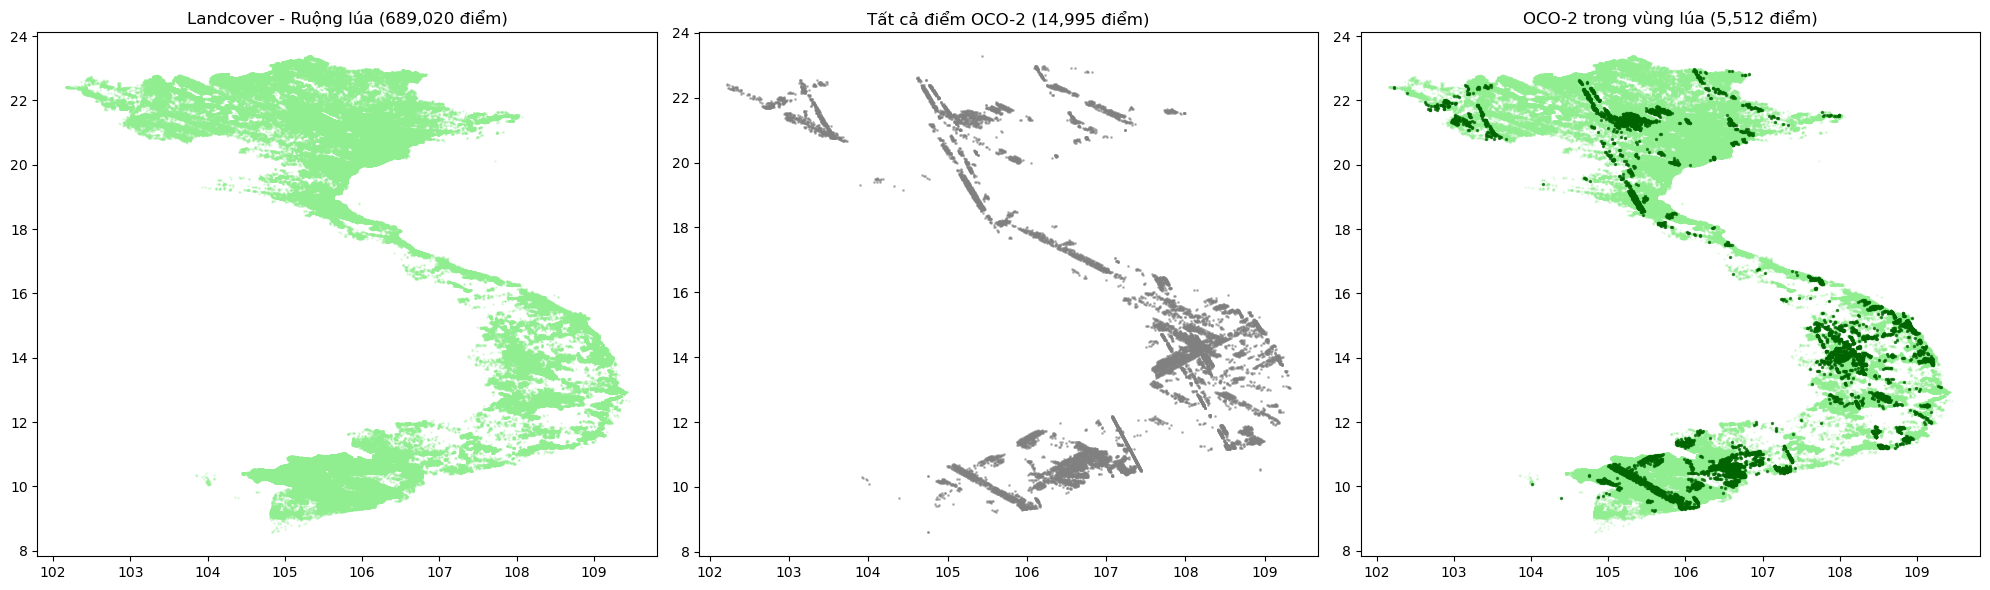


HOÀN THÀNH!


In [13]:
if __name__ == "__main__":
    main()
